<a href="https://colab.research.google.com/github/Bhanu-Prakash-Arri/Bhanu-Prakash-Arri.github.io/blob/master/contextual%20bandit%20approach%20to%20personalized%20news%20reccomendation%20system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta

sns.set_style("whitegrid")

class Environment:
    def __init__(self, variants, payouts, n_trials, variance=False):
        self.variants = variants
        if variance:
            self.payouts = np.clip(payouts + np.random.normal(0, 0.04, size=len(variants)), 0, .2)
        else:
            self.payouts = payouts
        #self.payouts[5] = self.payouts[5] if i < n_trials/2 else 0.1
        self.n_trials = n_trials
        self.total_reward = 0
        self.n_k = len(variants)
        self.shape = (self.n_k, n_trials)
        
    def run(self, agent):
        """Run the simulation with the agent. 
        agent must be a class with choose_k and update methods."""
        
        for i in range(self.n_trials):
            # agent makes a choice
            x_chosen = agent.choose_k()
            # Environment returns reward
            reward = np.random.binomial(1, p=self.payouts[x_chosen])
            # agent learns of reward
            agent.reward = reward
            # agent updates parameters based on the data
            agent.update()
            self.total_reward += reward
        
        agent.collect_data()
        
        return self.total_reward

class BaseSampler:
    
    def __init__(self, env, n_samples=None, n_learning=None, e=0.05):
        self.env = env
        self.shape = (env.n_k, n_samples)
        self.variants = env.variants
        self.n_trials = env.n_trials
        self.payouts = env.payouts
        self.ad_i = np.zeros(env.n_trials)
        self.r_i = np.zeros(env.n_trials)
        self.thetas = np.zeros(self.n_trials)
        self.regret_i = np.zeros(env.n_trials)
        self.thetaregret = np.zeros(self.n_trials)
        
        self.a = np.ones(env.n_k) 
        self.b = np.ones(env.n_k) 
        self.theta = np.zeros(env.n_k)
        self.data = None
        self.reward = 0
        self.total_reward = 0
        self.k = 0
        self.i = 0
        
        self.n_samples = n_samples
        self.n_learning = n_learning
        self.e = e
        self.ep = np.random.uniform(0, 1, size=env.n_trials)
        self.exploit = (1 - e)
        
    def collect_data(self):
        
        self.data = pd.DataFrame(dict(ad=self.ad_i, reward=self.r_i, regret=self.regret_i))

In [0]:
class RandomSampler(BaseSampler):
    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        
        self.k = np.random.choice(self.variants)
        
        return self.k
    
    def update(self):
        # nothing to update
        self.thetaregret[self.i] = np.max(self.theta) - self.theta[self.k]
        
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [0]:
class eGreedy(BaseSampler):

    def __init__(self, env, n_learning, e):
        super().__init__(env, n_learning, e)
        
    def choose_k(self):

        # e% of the time take a random draw from machines
        # random k for n learning trials, then the machine with highest theta
        self.k = np.random.choice(self.variants) if self.i < self.n_learning else np.argmax(self.theta)
        # with 1 - e probability take a random sample (explore) otherwise exploit
        self.k = np.random.choice(self.variants) if self.ep[self.i] > self.exploit else self.k
        return self.k

    def update(self):
        
        # update the probability of payout for each machine
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]
 
        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [0]:
class ThompsonSampler(BaseSampler):

    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        # sample from posterior (this is the thompson sampling approach)
        # this leads to more exploration because machines with > uncertainty can then be selected as the machine
        self.theta = np.random.beta(self.a, self.b)
        # select machine with highest posterior p of payout
        self.k = self.variants[np.argmax(self.theta)]
        return self.k
    
    def update(self):
       
        #update dist (a, b) = (a, b) + (r, 1 - r) 
        self.a[self.k] += self.reward
        self.b[self.k] += 1 - self.reward # i.e. only increment b when it's a swing and a miss. 1 - 0 = 1, 1 - 1 = 0

        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

Running multi-armed bandits with N_bandits = 10 and agent epsilon = 0.1
[Experiment 1/100]
  N_episodes = 10000
  bandit choice history = [5 9 9 ... 4 4 4]
  reward history = [0 1 1 ... 0 1 1]
  average reward = 0.7448

[Experiment 2/100]
  N_episodes = 10000
  bandit choice history = [1 1 1 ... 2 4 4]
  reward history = [1 0 0 ... 0 1 0]
  average reward = 0.7555

[Experiment 3/100]
  N_episodes = 10000
  bandit choice history = [9 9 9 ... 4 4 4]
  reward history = [1 0 1 ... 0 1 0]
  average reward = 0.7605

[Experiment 4/100]
  N_episodes = 10000
  bandit choice history = [7 7 7 ... 4 4 4]
  reward history = [1 1 1 ... 0 1 0]
  average reward = 0.7185

[Experiment 5/100]
  N_episodes = 10000
  bandit choice history = [10 10 10 ...  8  4  4]
  reward history = [1 1 1 ... 0 1 0]
  average reward = 0.7607

[Experiment 6/100]
  N_episodes = 10000
  bandit choice history = [2 2 9 ... 4 1 4]
  reward history = [1 0 0 ... 1 0 1]
  average reward = 0.7652

[Experiment 7/100]
  N_episodes = 

FileNotFoundError: ignored

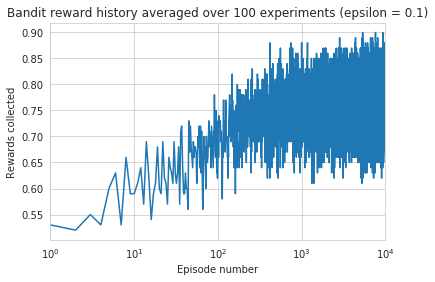

In [13]:
#solving multi armed bandits.py
import numpy as np
import matplotlib.pyplot as plt

def main():
    # =========================
    # Settings
    # =========================
    bandit_probs = [0.10, 0.50, 0.60, 0.80, 0.10,
                    0.25, 0.60, 0.45, 0.75, 0.65]  # bandit probabilities of success
    N_experiments = 100  # number of experiments to perform
    N_episodes = 10000  # number of episodes per experiment
    epsilon = 0.1  # probability of random exploration (fraction)
    save_fig = True  # if false -> plot, if true save as file in same directory

    # =========================
    # Define Bandit and Agent class
    # =========================
    class Bandit:

        def __init__(self, bandit_probs):
            self.N = len(bandit_probs)  # number of bandits
            self.prob = bandit_probs  # success probabilities for each bandit

        # Get reward (1 for success, 0 for failure)
        def get_reward(self, action):
            rand = np.random.random()  # [0.0,1.0)
            reward = 1 if (rand < self.prob[action]) else 0
            return reward

    class Agent:

        def __init__(self, bandit, epsilon):
            self.epsilon = epsilon
            self.k = np.zeros(bandit.N, dtype=np.int)  # number of times action was chosen
            self.Q = np.zeros(bandit.N, dtype=np.float)  # estimated value

        # Update Q action-value using:
        # Q(a) <- Q(a) + 1/(k+1) * (r(a) - Q(a))
        def update_Q(self, action, reward):
            self.k[action] += 1  # update action counter k -> k+1
            self.Q[action] += (1./self.k[action]) * (reward - self.Q[action])

        # Choose action using an epsilon-greedy agent
        def get_action(self, bandit, force_explore=False):
            rand = np.random.random()  # [0.0,1.0)
            if (rand < self.epsilon) or force_explore:
                action_explore = np.random.randint(bandit.N)  # explore random bandit
                return action_explore
            else:
                #action_greedy = np.argmax(self.Q)  # exploit best current bandit
                action_greedy = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
                return action_greedy

    # =========================
    # Define an experiment
    # =========================
    def experiment(agent, bandit, N_episodes):
        action_history = []
        reward_history = []
        for episode in range(N_episodes):
            # Choose action from agent (from current Q estimate)
            action = agent.get_action(bandit)
            # Pick up reward from bandit for chosen action
            reward = bandit.get_reward(action)
            # Update Q action-value estimates
            agent.update_Q(action, reward)
            # Append to history
            action_history.append(action)
            reward_history.append(reward)
        return (np.array(action_history), np.array(reward_history))

    # =========================
    #
    # Start multi-armed bandit simulation
    #
    # =========================
    N_bandits = len(bandit_probs)
    print("Running multi-armed bandits with N_bandits = {} and agent epsilon = {}".format(N_bandits, epsilon))
    reward_history_avg = np.zeros(N_episodes)  # reward history experiment-averaged
    action_history_sum = np.zeros((N_episodes, N_bandits))  # sum action history
    for i in range(N_experiments):
        bandit = Bandit(bandit_probs)  # initialize bandits
        agent = Agent(bandit, epsilon)  # initialize agent
        (action_history, reward_history) = experiment(agent, bandit, N_episodes)  # perform experiment

        if (i + 1) % (N_experiments / 100) == 0:
            print("[Experiment {}/{}]".format(i + 1, N_experiments))
            print("  N_episodes = {}".format(N_episodes))
            print("  bandit choice history = {}".format(
                action_history + 1))
            print("  reward history = {}".format(
                reward_history))
            print("  average reward = {}".format(np.sum(reward_history) / len(reward_history)))
            print("")
        # Sum up experiment reward (later to be divided to represent an average)
        reward_history_avg += reward_history
        # Sum up action history
        for j, (a) in enumerate(action_history):
            action_history_sum[j][a] += 1

    reward_history_avg /= np.float(N_experiments)
    print("reward history avg = {}".format(reward_history_avg))

    # =========================
    # Plot reward history results
    # =========================
    plt.plot(reward_history_avg)
    plt.xlabel("Episode number")
    plt.ylabel("Rewards collected".format(N_experiments))
    plt.title("Bandit reward history averaged over {} experiments (epsilon = {})".format(N_experiments, epsilon))
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    plt.xlim([1, N_episodes])
    if save_fig:
        output_file = "output/rewards.png"
        plt.savefig(output_file, bbox_inches="tight")
    else:
        plt.show()

    # =========================
    # Plot action history results
    # =========================
    plt.figure(figsize=(18, 12))
    for i in range(N_bandits):
        action_history_sum_plot = 100 * action_history_sum[:,i] / N_experiments
        plt.plot(list(np.array(range(len(action_history_sum_plot)))+1),
                 action_history_sum_plot,
                 linewidth=5.0,
                 label="Bandit #{}".format(i+1))
    plt.title("Bandit action history averaged over {} experiments (epsilon = {})".format(N_experiments, epsilon), fontsize=26)
    plt.xlabel("Episode Number", fontsize=26)
    plt.ylabel("Bandit Action Choices (%)", fontsize=26)
    leg = plt.legend(loc='upper left', shadow=True, fontsize=26)
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    plt.xlim([1, N_episodes])
    plt.ylim([0, 100])
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(16.0)
    if save_fig:
        output_file = "output/actions.png"
        plt.savefig(output_file, bbox_inches="tight")
    else:
        plt.show()

# Driver
if __name__ == "__main__":
    main()

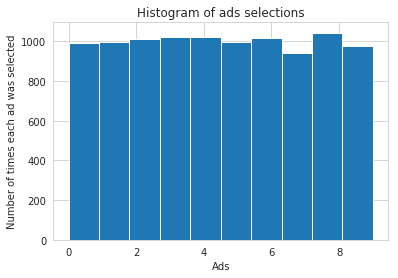

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('Ads_CTR_Optimisation.csv')

# Implementing Random Selection
import random
N = 10000
d = 10
ads_selected = []
total_reward = 0
for n in range(0, N):
    ad = random.randrange(d)
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    total_reward = total_reward + reward

# Visualising the results
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()

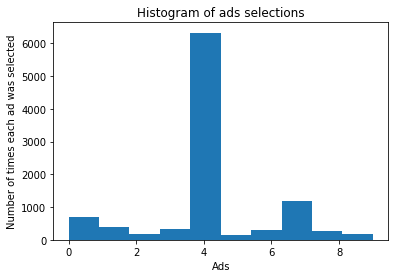

In [5]:
# Upper Confidence Bound

# Importing the dataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
# Importing the dataset

dataset = pd.read_csv('Ads_CTR_Optimisation.csv')

# Implementing UCB
ads_selected = []
N = 10000
d = 10
numbers_of_selections = [0] * d
sums_of_rewards = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    for i in range(0, d):
        if(numbers_of_selections[i] > 0):
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]  
            delta_i = math.sqrt(3/2 * math.log(n + 1) / numbers_of_selections[i])
            upper_bound = average_reward + delta_i 
        else:
            upper_bound = 1e400
        if(upper_bound > max_upper_bound):
            max_upper_bound = upper_bound
            ad = i
    ads_selected.append(ad)    
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1   
    reward = dataset.values[n, ad]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward        
    total_reward = total_reward + reward        
        
# Visualising the results

plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()
